### DS_7331 Machine Learning - Mini Lab Logistic Regression and SVMs- Group 4

##### Paticia Attah
##### Linda Eliasen

Using logistic regression and SVM we will predict the case status (certified / non certified) of an application submitted by the employer to hire non-immigrant workers under the H-1B visa program. Employers can hire non-immigrant workers only after their LCA petition is certified. The certified LCA petition is then submitted as part of the Petition for a Non-immigrant Worker application for work authorizations for H-1B visa status.

The goal is to uncover insights that can help employers understand the process of getting their LCA approved. The results will help employers understand which applications that they may consider submitting will be certified.  This information is important to an employer's buisness operations.  It can pinpoint errors or informtion on the appication that may need adjusting to avoid processing delays and also drive the recruiting strategy in denial situations.  

Measures of success include accuracy, precision, recall and utltimatley the F Score, which we will compare among models.

The H-1B Dataset contains data from employers Labor Condition Applications and the case certification determinations processed by the Office of Foreign Labor Certification (OFLC) where the date of the determination was issued on or after October 1, 2016 and on or before June 30, 2017.

We are using the cleaned, balanced dataset from the EDA process.  As noted during that phase, the dataset was highly unbalanced with 98% of the observations in the certified/certified withdrawn by employer categories and <2% in the denied category.  

#### Preparing the Data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import statsmodels.api as sm 
import numpy as np
import random
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

<AxesSubplot:title={'center':'count (target)'}>

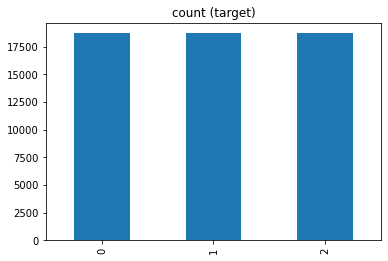

In [17]:
df = pd.read_csv ('Balanced_Visa_Data.csv')
df = df.sample(frac = 1) 
df['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

In [18]:
# Combining Certified & Certified Withdrawn by Employer as Certified

df1 = df.loc[(df['CASE_STATUS_CODE']==0) | (df['CASE_STATUS_CODE']==2)] 
df1['CASE_STATUS_CODE'] = np.select([df1.CASE_STATUS_CODE==0],[0],1)
np.unique(df1.CASE_STATUS_CODE)

array([0, 1])

In [19]:
df1.shape
df1.columns

Index(['Unnamed: 0', 'SOC_GROUP_Code', 'TOTAL_WORKERS', 'NEW_EMPLOYMENT',
       'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT',
       'NEW_CONCURRENT_EMPLOYMENT', 'ANNUALIZED_PREVAILING_WAGE',
       'PREVAILING_WAGE', 'ANNUALIZED_WAGE_RATE_OF_PAY', 'WAGE_RATE_OF_PAY',
       'DAYS_PROCESS', 'EMPLOYER_NAME_CODE', 'EMPLOYER_CITY_CODE',
       'SOC_NAME_CODE', 'SOC_GROUP_CODE', 'EMPLOYER_STATE_CODE',
       'AGENT_REPRESENTING_EMPLOYER_CODE', 'JOB_TITLE_CODE',
       'WILLFUL_VIOLATOR_CODE', 'WORKSITE_CITY_CODE', 'WORKSITE_STATE_CODE',
       'PW_UNIT_OF_PAY_CODE', 'PW_WAGE_LEVEL_CODE', 'WAGE_UNIT_OF_PAY_CODE',
       'H1B_DEPENDENT_CODE', 'SUPPORT_H1B_CODE', 'LABOR_CON_AGREE_CODE',
       'CASE_STATUS_CODE', 'EMPLOYER_NAME', 'EMPLOYER_CITY', 'SOC_NAME',
       'SOC_GROUP', 'EMPLOYER_STATE', 'AGENT_REPRESENTING_EMPLOYER',
       'JOB_TITLE', 'WILLFUL_VIOLATOR', 'WORKSITE_CITY', 'WORKSITE_STATE',
       'PW_UNIT_OF_PAY', 'PW_WAGE_LEVEL', 'WAGE_UNIT_OF_PAY', 'H1B_DEPENDENT',
      

In [20]:
sett = set(df1.SOC_GROUP_CODE)
#len(sett)

In [21]:
df2 = df1.drop(['CASE_STATUS','EMPLOYER_NAME_CODE', 'EMPLOYER_CITY_CODE',
           'SOC_NAME_CODE', 'EMPLOYER_STATE_CODE','WILLFUL_VIOLATOR_CODE',
           'AGENT_REPRESENTING_EMPLOYER_CODE', 'JOB_TITLE_CODE', 'EMPLOYER_STATE',
           'WORKSITE_CITY_CODE', 'WORKSITE_STATE_CODE', 'WORKSITE_STATE',
           'PW_UNIT_OF_PAY_CODE', 'PW_UNIT_OF_PAY', 'PW_WAGE_LEVEL_CODE', 'WAGE_UNIT_OF_PAY',
            'WAGE_UNIT_OF_PAY_CODE', 'H1B_DEPENDENT_CODE', 'SUPPORT_H1B_CODE', 'LABOR_CON_AGREE_CODE',
           'Unnamed: 0','WORKSITE_CITY','EMPLOYER_NAME',
            'EMPLOYER_CITY','WILLFUL_VIOLATOR_CODE', 'WORKSITE_CITY_CODE',
            'SOC_GROUP_Code','SOC_NAME','JOB_TITLE','SOC_GROUP_CODE'], axis=1)

In [22]:
SOC_GROUP = pd.get_dummies(df2['SOC_GROUP'],drop_first=True)
df2 = pd.concat([df2, SOC_GROUP], axis=1)

In [23]:
AGENT_REPRESENTING_EMPLOYER = pd.get_dummies(df2.AGENT_REPRESENTING_EMPLOYER, prefix='AGENT_REP',drop_first=True)
df2 = pd.concat([df2, AGENT_REPRESENTING_EMPLOYER], axis=1)            

In [24]:
WILLFUL_VIOLATOR = pd.get_dummies(df2.WILLFUL_VIOLATOR, prefix='WILL_VIOL',drop_first=True)
df2 = pd.concat([df2, WILLFUL_VIOLATOR], axis=1)

PW_WAGE_LEVEL = pd.get_dummies(df2.PW_WAGE_LEVEL, prefix='PW_LEVEL',drop_first=True)
df2 = pd.concat([df2, PW_WAGE_LEVEL], axis=1)

H1B_DEPENDENT = pd.get_dummies(df2.H1B_DEPENDENT, prefix='H1B_DEP',drop_first=True)
df2 = pd.concat([df2, H1B_DEPENDENT], axis=1)

LABOR_CON_AGREE = pd.get_dummies(df2.LABOR_CON_AGREE, prefix='LABOR_CON_AGREE',drop_first=True)
df2 = pd.concat([df2, LABOR_CON_AGREE], axis=1)

SUPPORT_H1B = pd.get_dummies(df2.SUPPORT_H1B, prefix='SUPPORT_H1B',drop_first=True)
df2 = pd.concat([df2, SUPPORT_H1B], axis=1)

In [25]:
df3 = df2.drop(['WILLFUL_VIOLATOR', 'PW_WAGE_LEVEL',
           'H1B_DEPENDENT','LABOR_CON_AGREE',
                'AGENT_REPRESENTING_EMPLOYER','SOC_GROUP','SUPPORT_H1B'], axis=1)

In [26]:
#Checking Ouput of reconfigured data

pd.set_option('display.max_columns', 100)
df3.head()

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,ANNUALIZED_PREVAILING_WAGE,PREVAILING_WAGE,ANNUALIZED_WAGE_RATE_OF_PAY,WAGE_RATE_OF_PAY,DAYS_PROCESS,CASE_STATUS_CODE,"Arts, Design, Entertainment, Sports, and Media",Building and Grounds Cleaning and Maintenance,Business and Financial Operations,Community and Social Service,Computer and Mathematical,Construction and Extraction,"Education, Training, and Library",Food Preparation and Serving Related,Healthcare Practitioners and Technical,Healthcare Support,"Installation, Maintenance, and Repair",Legal,"Life, Physical, and Social Science",Management,Office and Administrative Support,Personal Care and Service,Production,Sales and Related,Transportation and Material Moving,AGENT_REP_Y,WILL_VIOL_Y,H1B_DEP_Y,LABOR_CON_AGREE_Y,SUPPORT_H1B_Y
39264,3,1,0,0,0,73272.74998,73272.74998,73162.74652,73162.74652,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
52478,1,1,0,0,0,61500.00000,61500.00000,61500.00000,61500.00000,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
38813,1,1,0,0,0,63315.00000,63315.00000,64000.00000,64000.00000,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
53885,3,2,0,0,0,73883.58974,73883.58974,78000.00000,78000.00000,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
11263,1,0,0,0,0,70866.00000,70866.00000,70866.00000,70866.00000,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


Our reconfigured dataset contains 37,420 Observations and 54 Features

In [27]:
df3 = pd.concat([df3, SOC_GROUP], axis=1)
df3.shape

(37420, 54)

### SECTION 1 - CREATE MODELS:  Logistic Regression and SVM 

Preparing the training and testing subsets - - Scaling the data

The data is wide-spread for wage features, days processed and total workers, which will skew against the other features which are primarily yes/no.

Scaling the data brings all values onto one scale to minimize the effects of this.

In [28]:
# divide data set to x and y and Scale data
from sklearn import preprocessing

y = df3['CASE_STATUS_CODE']
x = df3.drop(['CASE_STATUS_CODE'], axis=1)
x = preprocessing.scale(x) 

a = df3['CASE_STATUS_CODE'].values
bb = df3.drop(['CASE_STATUS_CODE'], axis=1)
b = bb.values
b = preprocessing.scale(b) 

x_t = x[:7484]
y_t = y[:7484]

print(x_t.shape)
print(y_t.shape)

(7484, 53)
(7484,)


In [29]:
# create train set

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
print(y_train.shape)
print(x_test.shape)

(29936,)
(7484, 53)


## Logistic Regression

In [31]:
# grid search optimization with 10 crossfold validation
#Grid search builds a model for every combination of hyperparameters specified 
#and evaluates each model

params = {
    'penalty':['l1','l2'],        # l1 is Lasso, l2 is Ridge
    'solver':['liblinear'],
    'C': [1,10,100]
}

lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, cv=10, verbose=1).fit(x_train, y_train)

print ("Best Params", lr_gs.best_params_)
print ("Best Score", lr_gs.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   31.6s finished


Best Params {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score 0.8420630435612286


The best model identified with a score of 84.2% will use Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function. Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether.

https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c

Training the Model & Checking Accuracy

In [32]:
# logistic regression

lg = LogisticRegression(penalty='l1',solver='liblinear', random_state=0,C=10.0)
lg.fit(x_train,y_train)

LogisticRegression(C=10.0, penalty='l1', random_state=0, solver='liblinear')

In [33]:
# cross validation = 10

from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 10
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2)

In [34]:
# accuracies fom cross validation

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lg, x_t, y=y_t, cv=cv_object)
print(accuracies)

[0.83967936 0.83433534 0.85571142 0.8496994  0.85303941 0.82765531
 0.83834335 0.83967936 0.83166333 0.84301937]


Logistic Regression Predictions

In [40]:
# predictions for logistic regression

y_pred = lg.predict(x_test)

Comparing regression results and feature weights

In [41]:
# pull logistic regrssion results
pd.set_option('display.max_rows', None)

accuracy_score(y_test, y_pred)
coef = lg.coef_
coefs = []
features = bb.columns

for i in coef[0]:
    coefs.append(round(i,6))
    
coef_abs = [abs(i) for i in coefs] 
    
weight = list(zip(features,coefs,coef_abs))
df_weights = pd.DataFrame(weight, columns = ['feature_names', 'coef','coef_abs']) 
df_weight = df_weights.sort_values(by=['coef_abs'], )
df_weight = df_weight.drop_duplicates()

In [42]:
df_weight

,feature_names,coef,coef_abs
27,Sales and Related,0.000000,0.000000
24,Office and Administrative Support,0.000529,0.000529
6,PREVAILING_WAGE,0.004000,0.004000
52,Transportation and Material Moving,-0.007655,0.007655
23,Management,-0.009276,0.009276
10,"Arts, Design, Entertainment, Sports, and Media",0.015696,0.015696
47,Management,-0.017123,0.017123
28,Transportation and Material Moving,-0.020366,0.020366
51,Sales and Related,-0.024565,0.024565
36,Business and Financial Operations,0.028342,0.028342


In [43]:
df_weight.shape

(53, 3)

In [44]:
#Absolute Value comparison coefficients >4.0

df_weights = df_weight

df_weights = df_weights[df_weights['coef_abs'] > 0.4]
df_weights

,feature_names,coef,coef_abs
45,Legal,0.464611,0.464611
39,Construction and Extraction,0.474047,0.474047
19,Healthcare Support,0.494069,0.494069
15,Construction and Extraction,0.575499,0.575499
1,NEW_EMPLOYMENT,-0.577563,0.577563
35,Building and Grounds Cleaning and Maintenance,0.590746,0.590746
29,AGENT_REP_Y,-0.676144,0.676144
37,Community and Social Service,0.691782,0.691782
17,Food Preparation and Serving Related,0.709983,0.709983
31,H1B_DEP_Y,-0.711799,0.711799


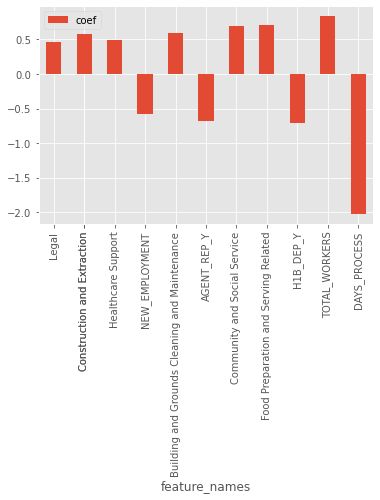

In [45]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


ax = df_weights.plot.bar(y='coef', x = 'feature_names')
plt.show()

In [46]:
# logistic regression coefficients

print(coef)

[[ 8.34535636e-01 -5.77562896e-01 -3.71153235e-01 -2.91856412e-01
   7.52304069e-02  2.99060082e-02  4.00046444e-03  1.15077394e-01
  -1.58242834e-01 -2.02509003e+00  1.56956947e-02  2.88507933e-01
   1.17880346e-01  1.11344300e-01  4.76376018e-02  5.75498815e-01
   1.61107603e-01  7.09983316e-01  3.52513520e-02  4.94068953e-01
   1.62157579e-01  2.65921404e-01  1.36585848e-01 -9.27630744e-03
   5.28583931e-04  1.20223672e-01  1.25758284e-01  0.00000000e+00
  -2.03655196e-02 -6.76143519e-01 -6.12981465e-02 -7.11798948e-01
   1.61784181e-01 -3.62139738e-01  1.75342649e-01  5.90746380e-01
   2.83421120e-02  6.91781597e-01  8.76965276e-02  4.74046646e-01
   8.40162737e-02  3.45051772e-01  7.73526649e-02  2.40696916e-01
   2.21343012e-01  4.64610543e-01  3.77166350e-02 -1.71231128e-02
   9.63846501e-02  1.23826417e-01  9.12630750e-02 -2.45646925e-02
  -7.65519278e-03]]


In [47]:
df3.shape

(37420, 54)

Logistic Regression Accuracy Metrics

In [48]:
from sklearn import metrics as mt

In [49]:
iter_num=0
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    lg.fit(b[train_indices],a[train_indices])  # train object
    y_hat = lg.predict(b[test_indices])
    
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(a[test_indices],y_hat))
    print("precision", mt.precision_score(a[test_indices],y_hat)) 
    print("recall", mt.recall_score(a[test_indices],y_hat)) 
    print("f1-score", mt.f1_score(a[test_indices],y_hat))
    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
    print(classification_report(a[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.848743987172635
precision 0.8606716625034694
recall 0.8311444652908068
f1-score 0.8456503954185983
confusion matrix
 [[3251  502]
 [ 630 3101]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      3753
           1       0.86      0.83      0.85      3731

    accuracy                           0.85      7484
   macro avg       0.85      0.85      0.85      7484
weighted avg       0.85      0.85      0.85      7484

====Iteration 1  ====
accuracy 0.852618920363442
precision 0.8623726947426369
recall 0.8385974304068522
f1-score 0.8503189035147238
confusion matrix
 [[3248  500]
 [ 603 3133]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      3748
           1       0.86      0.84      0.85      3736

    accuracy                           0.85      7484
   macro avg       0.85      0.85      0.85      7484
weighted avg       0.85      0.85      0.85    

## Support Vector Machines

Note that due to the size of the dataset it had to be reduced in order for the SVM to run.  The dataset used for Logistic Regression had 37,420 Observations compared to 11,420 used for SVM

In [50]:
# reducing data set size for SVC

df4=df3.sort_values(by=['CASE_STATUS_CODE'])
df4=df4.iloc[13000:, :]
df4=df4.iloc[:11420, :]
df4.shape

(11420, 54)

In [51]:
df4 = df4.sample(frac = 1) 
df4.head(5)

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,ANNUALIZED_PREVAILING_WAGE,PREVAILING_WAGE,ANNUALIZED_WAGE_RATE_OF_PAY,WAGE_RATE_OF_PAY,DAYS_PROCESS,CASE_STATUS_CODE,"Arts, Design, Entertainment, Sports, and Media",Building and Grounds Cleaning and Maintenance,Business and Financial Operations,Community and Social Service,Computer and Mathematical,Construction and Extraction,"Education, Training, and Library",Food Preparation and Serving Related,Healthcare Practitioners and Technical,Healthcare Support,"Installation, Maintenance, and Repair",Legal,"Life, Physical, and Social Science",Management,Office and Administrative Support,Personal Care and Service,Production,Sales and Related,Transportation and Material Moving,AGENT_REP_Y,WILL_VIOL_Y,H1B_DEP_Y,LABOR_CON_AGREE_Y,SUPPORT_H1B_Y,"Arts, Design, Entertainment, Sports, and Media",Building and Grounds Cleaning and Maintenance,Business and Financial Operations,Community and Social Service,Computer and Mathematical,Construction and Extraction,"Education, Training, and Library",Food Preparation and Serving Related,Healthcare Practitioners and Technical,Healthcare Support,"Installation, Maintenance, and Repair",Legal,"Life, Physical, and Social Science",Management,Office and Administrative Support,Personal Care and Service,Production,Sales and Related,Transportation and Material Moving
17912,1,0,1,0,0,78603.00000,78603.00000,78603.00000,78603.00000,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38500,1,0,0,0,0,55616.32091,55616.32091,60011.07502,60011.07502,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38828,1,0,0,0,0,64800.93098,64800.93098,65000.00000,65000.00000,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
17086,1,1,0,0,0,60944.00000,60944.00000,60944.00000,60944.00000,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42451,1,0,0,0,0,89973.15760,89973.15760,89971.21307,89971.21307,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'count (target)'}>

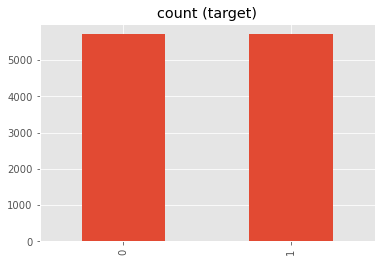

In [52]:
df4['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

Preparing the training and testing subsets - - Scaling the data

In [53]:
from sklearn import svm

In [54]:
# Reduced data set preprocessing for SVM
# divide data set to x and y and Scale data
from sklearn import preprocessing

y = df4['CASE_STATUS_CODE']
x = df4.drop(['CASE_STATUS_CODE'], axis=1)
x = preprocessing.scale(x) 

a = df4['CASE_STATUS_CODE'].values
bb = df4.drop(['CASE_STATUS_CODE'], axis=1)
b = bb.values
b = preprocessing.scale(b) 

x_t = x[:2284]
y_t = y[:2284]

print(x_t.shape)
print(y_t.shape)

(2284, 53)
(2284,)


In [55]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
print(y_train.shape)
print(x_test.shape)

(9136,)
(2284, 53)


In [56]:
# Grid search
sv = GridSearchCV(svm.SVC(gamma='auto',random_state=89),{
            'C':[1,10,100],
                'kernel':['rbf']}, cv=10, verbose=1,)

sv_gs = sv.fit(x_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


In [47]:
print ("Best Params", sv_gs.best_params_)
print ("Best Score", sv_gs.best_score_)

Best Params {'C': 100, 'kernel': 'rbf'}
Best Score 0.8821149209702744


The best model identified with a score of 88.2% will use the RBF Kernel along with a C Parameter of 100 to control the outliers.

Training the Model & Checking Accuracy

In [57]:
sv = svm.SVC(C=100,kernel= 'rbf',random_state=89)
sv.fit(x_train, y_train)
y_predsv = sv.predict(x_test)

In [58]:
iter_num=0
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    sv.fit(b[train_indices],a[train_indices])  # train object
    y_hat = sv.predict(b[test_indices])
    
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(a[test_indices],y_hat)) 
    print("precision", mt.precision_score(a[test_indices],y_hat)) 
    print("recall", mt.recall_score(a[test_indices],y_hat)) 
    print("f1-score", mt.f1_score(a[test_indices],y_hat))
    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
    print(classification_report(a[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8708406304728546
precision 0.9135338345864662
recall 0.8272340425531914
f1-score 0.8682447521214828
confusion matrix
 [[1017   92]
 [ 203  972]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1109
           1       0.91      0.83      0.87      1175

    accuracy                           0.87      2284
   macro avg       0.87      0.87      0.87      2284
weighted avg       0.87      0.87      0.87      2284

====Iteration 1  ====
accuracy 0.8787215411558669
precision 0.9194956353055286
recall 0.830122591943958
f1-score 0.8725264611136677
confusion matrix
 [[1059   83]
 [ 194  948]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.88      1142
           1       0.92      0.83      0.87      1142

    accuracy                           0.88      2284
   macro avg       0.88      0.88      0.88      2284
weighted avg       0.88      0.88      0.88   

In [59]:
# to call the suppport vector foe each variable use the [column index]

svc = sv.support_vectors_
svc.shape

(2508, 53)

In [60]:
len(svc[0])

53

In [63]:
svc[2507]

array([-0.20491024, -0.4270169 , -0.3692568 , -0.17364655, -0.07164526,
        0.09385279,  0.26304423, -0.22253887,  0.07397045, -0.39606861,
       -0.10085876, -0.08659617, -0.17885715, -0.13917547,  0.44744854,
       -0.09398895, -0.08912639, -0.09771071, -0.09398895, -0.08020859,
       -0.07328159, -0.06828338, -0.07909525, -0.12329376, -0.03626586,
       -0.02960446, -0.0229275 , -0.02808403,  0.        ,  1.76376618,
       -0.04188539,  0.42927701,  0.23857513,  0.39672828, -0.10085876,
       -0.08659617, -0.17885715, -0.13917547,  0.44744854, -0.09398895,
       -0.08912639, -0.09771071, -0.09398895, -0.08020859, -0.07328159,
       -0.06828338, -0.07909525, -0.12329376, -0.03626586, -0.02960446,
       -0.0229275 , -0.02808403,  0.        ])

#### Assess how well each model performs

Logistic Regression, (run on the full dataset) had an overall accuracy of 85.3% on the best iteration.   SVM (run on a subset of the data) had an overall accuracy of 89% on the best iteration.  The other effectivenss measures are shown below.

Since SVM was run on a subset of the data we cannot come to the conclusion that it was a more effective model vs. Logistic Regression.

Based on the fact that we were able to use Logistic Regression on the full dataset, our preference is to use that model for the data.  

Logistic Regression Model Effectiveness Measures

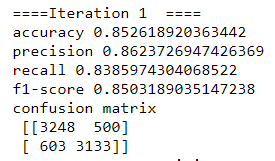

Support Vector Machines Effectiveness Measures

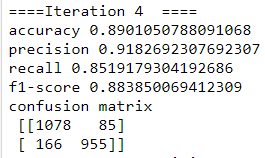

### SECTION 2 - Model Advantages

As stated above, Logistic Regression had an overall accuracy of 85.3% and SVM had an overall accuracy of 89%.

We were not able to run SVM on the full dataset.  Since the performance measures are based on a subset of the data we cannot come to the conclusion that it was a more effective model vs. Logistic Regression.

Logistic regression is preferred in cases of a binary outcome (T/F, Y/N) and the objective is to determine if a new sample fits best into a category as it is simpler and more efficient.  Examples of problems where logistic regression is applied include cancer detection (yes/no), test scores (pass/fail), marketing (customer will purchase or not).  

SVM is preferred for unstructured and semi-strutured data like text and images.  It is best when there is an understandable margin of dissociation between classes and is more efficient in high dimensional spaces or when the number of dimensions is larger than the number of specimans.

Based on the fact that we were able to use Logistic Regression on the full dataset, our preference is to use that model for the data.  The model was quick to run and we could interprate the results. We could not do this with the SVM Model. The logistic regression model not only provided a measure of how appropriate a feature was, but also provided the diretion of association so we could interpret the feature importance to the model.  

The downside in using Logistic Regression as opposed to SVM is that Logistic Regression is vulnerable to overfitting because it constructs linear boundaries, so that needs to be taken into account.  Since SVM tries to find the best margin, this reduces that risk.  However, we applied Lasso Regularization to avoid overfitting, so this is not enough of a reason to sway our decision on model appropriateness.  Finally, as we discovered, SVM algorithms are not acceptable for large data sets.  




### SECTION 3 - Use the Weights from Logistic Regression to Interpret Feature Importance

Interpretation of Results

When running the model, the attributes were normalized to have the same dynamic range and are comparable.  For a binary outcome there is an assumption of a linear relationship and we can mathematically describe the influence of each variable on the likelihood of an application being certified with odds ratios by taking the exponent.

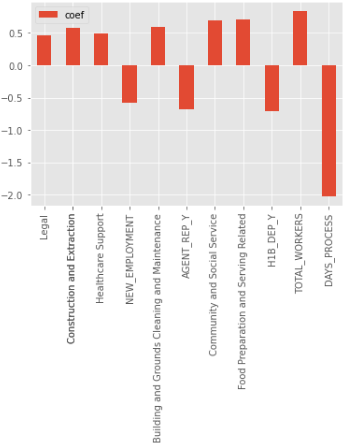

Days_Process (-2.025 / 13.2% change in odds of being certified) negatively impacts obtaining a certified status for an application.  For each additional day, This is reasonable as a longer review period could indicate issues with the appliacation or those requiring in-depth review as it may not meet the criteria for certification. These criteria include specialty occupation, wage rate lower than prevailing wage or wage level classification not aligned with complexity of role. 

H1B_Dep_Y (-0.712 / 49% change in odds of being certified) also has a larger impact on a negative certification result. This feature denotes that this is an employer who hires ‘too many’ H1B workers.  An H1B dependent employer is subject to additional attestation and paperwork requirements when filing for an H1B in an effort to protect U.S. workers. (https://www.visapro.com/resources/article/h1b-dependent-employer/)

Agent_Rep_Y (-0.676 / 50.9% change in odds of being certified)  This is curious as we would have expected that applications that had legal involvement would have improved chances of being certified based on an attorney's understanding of the legal process involved in obtaining a Visa.

New_Employment (-0.578 / 56.1% change in odds of being certified)  This suggests that it is easier to get an application certified if it is under recertification vs. a new application. 

Total_Workers (.835 / 230.5% change in odds of being certified) had a positive impact. Since this is a continuous variable, we need to investigate this further in order to determine if applications with more or less headcount impacts this.

From an Occupation Group perspective, those with the most positive impact were Food Preparation/Serving Related, Community/Social Services, Building Grounds & Construction and Extraction.

https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16

https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/?ref=rp

https://www.geeksforgeeks.org/support-vector-machine-algorithm/?ref=rp

https://sciphy-stats.com/post/interpreting-logistic-regression-coefficients-odds-ratios/


### SECTION 4 - Interpret Support Vectors